In [1]:
#Inspired / borrowed / stolen from: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

#Here we add some datetime and stats processing libraries. To test a time series stationarity, we'll use the Dickey Fuller test.

from datetime import datetime
from statsmodels.tsa.stattools import adfuller

In [2]:
#First, read in the data as a pandas dataframe
data = pd.read_csv('GoldHistoricalQuotes.csv')

In [3]:
#check the top of the dataframe using 'head'
data.head()

,Date,Close,Volume,Open,High,Low
0,8/31/20,1978.6,242577,1973.9,1985.8,1962.3
1,8/28/20,1974.9,329609,1937.5,1983.0,1928.2
2,8/27/20,1932.6,461990,1963.0,1987.0,1914.7
3,8/26/20,1952.5,338049,1939.0,1963.4,1908.4
4,8/25/20,1923.1,271641,1935.9,1944.1,1919.1


In [4]:
#convert the Date column into datetime object

data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

#check datatype of index
data.index

DatetimeIndex(['2020-08-31', '2020-08-28', '2020-08-27', '2020-08-26',
               '2020-08-25', '2020-08-24', '2020-08-21', '2020-08-20',
               '2020-08-19', '2020-08-18',
               ...
               '2010-09-15', '2010-09-14', '2010-09-13', '2010-09-10',
               '2010-09-09', '2010-09-08', '2010-09-07', '2010-09-03',
               '2010-09-02', '2010-09-01'],
              dtype='datetime64[ns]', name='Date', length=2519, freq=None)

In [5]:
#select a column for the time series:
ts = data['Close']
ts.head(10)

Date
2020-08-31    1978.6
2020-08-28    1974.9
2020-08-27    1932.6
2020-08-26    1952.5
2020-08-25    1923.1
2020-08-24    1939.2
2020-08-21    1947.0
2020-08-20    1946.5
2020-08-19    1970.3
2020-08-18    2013.1
Name: Close, dtype: float64

/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Gold Daily Closing Price')

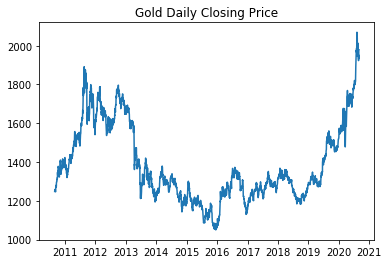

In [6]:
#check what a plot of it looks like using matplotlib
plt.plot(ts)
plt.title('Gold Daily Closing Price')

In [7]:
#thanks to Jacob for this handy stationarity function, saved me time writing it.
#There was a change in pandas on how to handle the rolling statistics and I updaed that in the function below

def test_stationarity(timeseries):
    
    #Determing rolling statistics. This was updated from the original post by Jacob
    rolmean = pd.Series(timeseries).rolling(window=20).mean()
    rolstd = pd.Series(timeseries).rolling(window=20).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

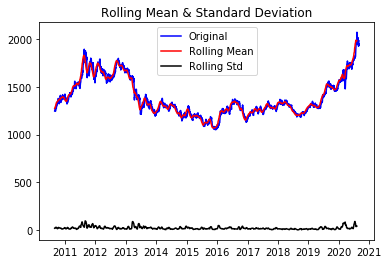

Results of Dickey-Fuller Test:
Test Statistic                   -3.185687
p-value                           0.020828
#Lags Used                        9.000000
Number of Observations Used    2509.000000
Critical Value (1%)              -3.432959
Critical Value (5%)              -2.862693
Critical Value (10%)             -2.567384
dtype: float64


In [8]:
#check the time series stationarity for Close
test_stationarity(ts)

## This time series is NOT stationary

What this means is that rolling mean is increasing but the standard deviation is flat or falling. Plus the test statistic (-3.18) is greater than the 1% Critical Value (-3.43). No good, this is probably in a trend. Duh.


In [9]:
#Convert time series into a log series
ts_log = np.log(ts)

In [10]:
#Let's try the some moving average differences
#First we create a 12 day rolling moving average in Pandas
moving_avg = pd.Series(ts_log).rolling(window=20).mean()

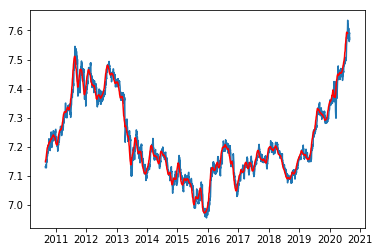

In [11]:
#Let's check the plots, looks good so far
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
#Now some magic, we subtract the log prices from the moving average and check them out.
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(20)

Date
2020-08-31         NaN
2020-08-28         NaN
2020-08-27         NaN
2020-08-26         NaN
2020-08-25         NaN
2020-08-24         NaN
2020-08-21         NaN
2020-08-20         NaN
2020-08-19         NaN
2020-08-18         NaN
2020-08-17         NaN
2020-08-14         NaN
2020-08-13         NaN
2020-08-12         NaN
2020-08-11         NaN
2020-08-10         NaN
2020-08-07         NaN
2020-08-06         NaN
2020-08-05         NaN
2020-08-04    0.020733
Name: Close, dtype: float64

In [13]:
#Note, there's a lot of NaN's because of the subtraction of the moving average from the price, so we drop them inplace
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(20)

Date
2020-08-04    0.020733
2020-08-03    0.003220
2020-07-31    0.002741
2020-07-30   -0.007801
2020-07-29   -0.003396
2020-07-28   -0.010942
2020-07-27   -0.015695
2020-07-24   -0.044465
2020-07-23   -0.046953
2020-07-22   -0.057471
2020-07-21   -0.064514
2020-07-20   -0.074235
2020-07-17   -0.074595
2020-07-16   -0.075455
2020-07-15   -0.064389
2020-07-14   -0.061073
2020-07-13   -0.054827
2020-07-10   -0.055664
2020-07-09   -0.047742
2020-07-08   -0.032555
Name: Close, dtype: float64

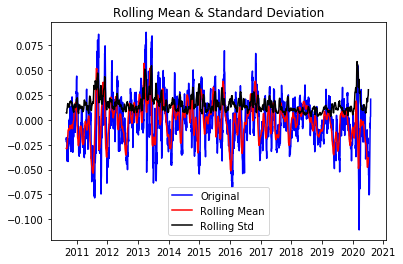

Results of Dickey-Fuller Test:
Test Statistic                -8.586283e+00
p-value                        7.492158e-14
#Lags Used                     1.900000e+01
Number of Observations Used    2.480000e+03
Critical Value (1%)           -3.432990e+00
Critical Value (5%)           -2.862706e+00
Critical Value (10%)          -2.567391e+00
dtype: float64


In [14]:
#Now let's check stationarity. 
test_stationarity(ts_log_moving_avg_diff)

## This is Stationary!

The test statistic is -8.58, it is smaller than than the 1% value of -3.43. Very nice. We are 99% confident that this is stationary with the data preprocessing we've done. Let's try a moving weighted average.

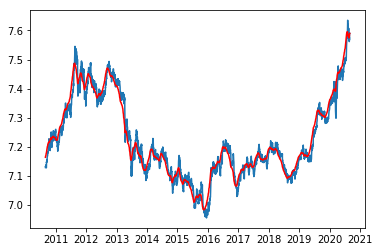

In [15]:
#Try EMWA
expweighted_avg = pd.DataFrame.ewm(ts_log, halflife=12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

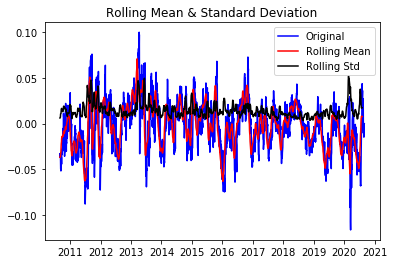

Results of Dickey-Fuller Test:
Test Statistic                -8.830970e+00
p-value                        1.770271e-14
#Lags Used                     1.000000e+00
Number of Observations Used    2.517000e+03
Critical Value (1%)           -3.432951e+00
Critical Value (5%)           -2.862689e+00
Critical Value (10%)          -2.567382e+00
dtype: float64


In [16]:
# Subtract out the log values from the expweighte average and test stationary
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

## This IS stationary.
Turns out that using an EWMA and substracting out the log creates a stationary time series. That is great!

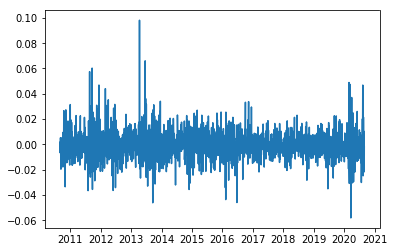

In [17]:
#Let's try to make predictions. First we shift the time series back by 1 day.

ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)


plt.plot(ts_log_diff)

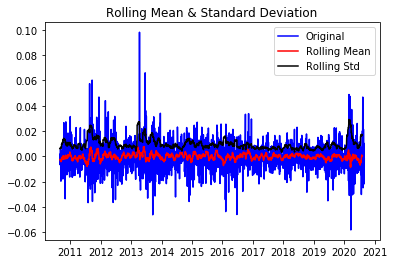

Results of Dickey-Fuller Test:
Test Statistic                  -52.124491
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2517.000000
Critical Value (1%)              -3.432951
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64


In [18]:
#Then we test if it's still stationary.
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## This is Stationary!
Turns out when you do the shift by one day, the Gold model remains stationary! Cool! Normally we don't have to do anything else here and go straight to the predictions (because we shifted it a day so we can predict 1 day ahead) but what if the results weren't Stationary, then we'd have to decompose the trenda and check for stationarity in the time series residuals. Let's do that for fun.


In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
decomposition = seasonal_decompose(ts_log, model="multiplicative", period=12)

In [21]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

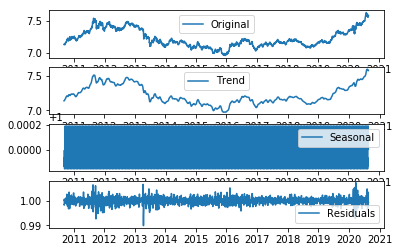

In [22]:
plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label="Seasonal")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc='best')

## This is in a Trend!
We are definately in a trend for the last part of the time series.

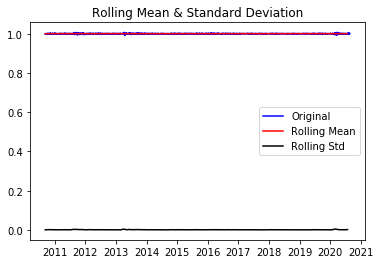

Results of Dickey-Fuller Test:
Test Statistic                -1.716857e+01
p-value                        6.767237e-30
#Lags Used                     2.200000e+01
Number of Observations Used    2.484000e+03
Critical Value (1%)           -3.432985e+00
Critical Value (5%)           -2.862704e+00
Critical Value (10%)          -2.567390e+00
dtype: float64


In [23]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## The Residuals of the Trend are  NOT Stationary

By default, a trend can not be stationary and we usually try to transform the residuals to see if they can be stationary. This is not working here but we were able to make the model stationary by shifting the ts one day.


In [24]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [25]:
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

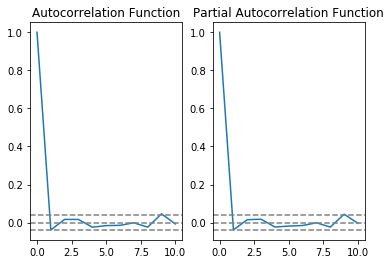

In [26]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout

/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been pro

Text(0.5,1,'RSS 0.0000')

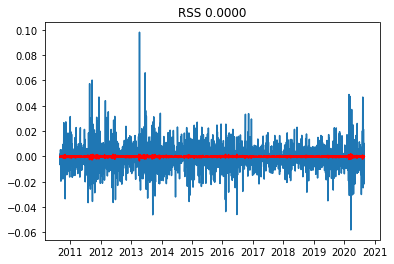

In [27]:
#ARIMA Model
model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS %.4f' %sum(results_ARIMA.fittedvalues-ts_log_diff)**2)

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2020-08-28   -0.000183
2020-08-27   -0.000122
2020-08-26    0.000557
2020-08-25   -0.000817
2020-08-24    0.000428
dtype: float64

In [29]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2020-08-28   -0.000183
2020-08-27   -0.000305
2020-08-26    0.000252
2020-08-25   -0.000565
2020-08-24   -0.000136
dtype: float64

In [30]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Date
2010-09-01    7.129259
2010-09-02    7.129839
2010-09-03    7.129481
2010-09-07    7.130022
2010-09-08    7.129979
dtype: float64

Text(0.5,1,'RMSE: 377.8088')

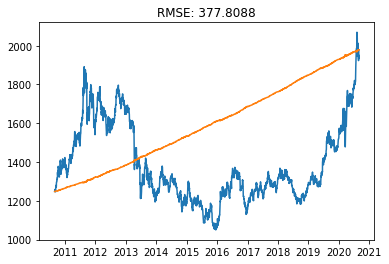

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

## NICE! But that last chart looks pretty crazy!
Maybe we should take the last 6 months of data (180 days) so we can model if the price continues to go up or down.


In [32]:
#Shif the ts_log and take a 180 day slice

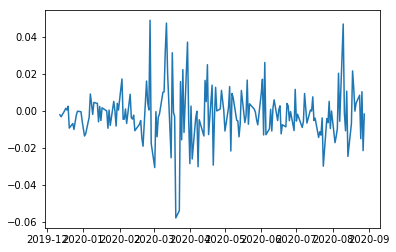

In [33]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)


plt.plot(ts_log_diff[:180])

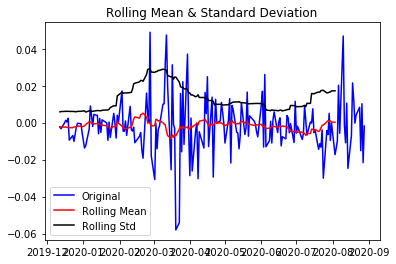

Results of Dickey-Fuller Test:
Test Statistic                -6.771586e+00
p-value                        2.633504e-09
#Lags Used                     6.000000e+00
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64


In [39]:
#Then we test if it's still stationary.
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff[:180])



<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

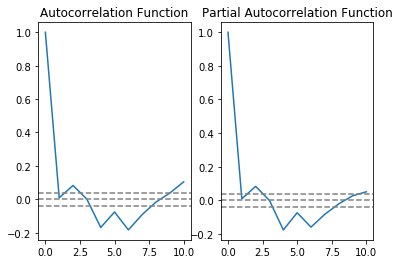

In [40]:
lag_acf = acf(ts_log_diff[:180], nlags=10)
lag_pacf = pacf(ts_log_diff[:180], nlags=10, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout

/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been pro

Text(0.5,1,'RSS nan')

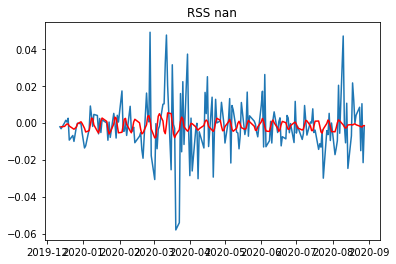

In [42]:
#ARIMA Model
model = ARIMA(ts_log[:180], order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff[:180])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS %.4f' %sum(results_ARIMA.fittedvalues-ts_log_diff)**2)

Text(0.5,1,'RMSE: 619.8376')

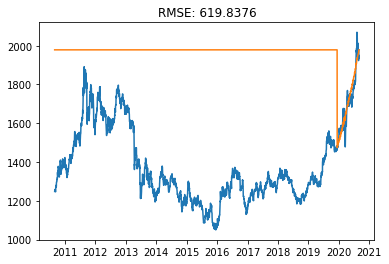

In [49]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))